In [34]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn
import LogisticRegression as lr

import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, confusion_matrix, roc_auc_score

# A ) 
Here we will load the dataset, then split it into train, validation and test data. 
As the Credit Card data is biased, we also create a downzised dataset.

In [35]:
# Reading in credit card dataset.
x,y = ld.load_data(scaler='minmax')

# Extracting all datapoints where the output is 1 (i.e paying credit card dept).
indices = np.where(y == 1)
indices_zero = np.where(y == 0)
# Randomly extracting equal amount of datapoints where the output is 0 (i.e defaulting).
datapoints = np.random.choice(indices_zero[0], size=y[indices[0]].shape[0], replace=False)

#Stacking the two datasets
x_new = np.vstack((x[indices[0],:],x[datapoints,:]))
y_new = np.vstack((y[indices[0]],y[datapoints]))

# Splitting data in train and test data
xtrain,xtest,ytrain,ytest = train_test_split(x_new,y_new, test_size=0.20, random_state= 0, shuffle=True)
# Splitting in train and validation
xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain, test_size=0.125, random_state= 0, shuffle=True)

# Extracting some useful shapes.
nx_train, ny_train = xtrain.shape
nx_test, ny_test = xtest.shape

# B) 
Egen logistic regression med gradient descent.


In [36]:
eta = 0.1 # learning rate
Niter=2500
k=5
y_folds, x_folds = lrf.k_fold_reshaper(k,y_new,x_new,shuffle=True)
norm = np.zeros([2,2])
accuracy_train = float()
accuracy_test = float()
f1_train = float()
f1_test = float()

for i in range(k):
    xtrain = x_folds[np.arange(len(x_folds))!=i]      # Featch all but the i-th element
    xtrain = np.concatenate(xtrain,axis=0)
    ytrain = y_folds[np.arange(len(y_folds))!=i]
    ytrain = np.concatenate(ytrain,axis=0)
    xtest  = x_folds[i]
    ytest  = y_folds[i]
    
    logreg = lr.LOGREG(eta=0.1, doplot = False, doprint=False)
    cost_test, cost_train, axis = logreg.fit(xtrain, ytrain, xtest, ytest, Niter, solver='gd')
    
    classified=logreg.predict(xtest)
    accuracy_test += 100*np.sum(classified==ytest)/len(classified)
    f1_test += f1_score(ytest, classified)
    norm += fx.norm_confusion_matrix(ytest, classified, normalize=True)
    
    classified=logreg.predict(xtrain)   
    accuracy_train += 100*np.sum(classified==ytrain)/len(classified)
    f1_train += f1_score(ytrain, classified)
    
norm = norm/k
accuracy_train = accuracy_train/k
accuracy_test = accuracy_test/k
f1_train = f1_train/k
f1_test = f1_test/k

    

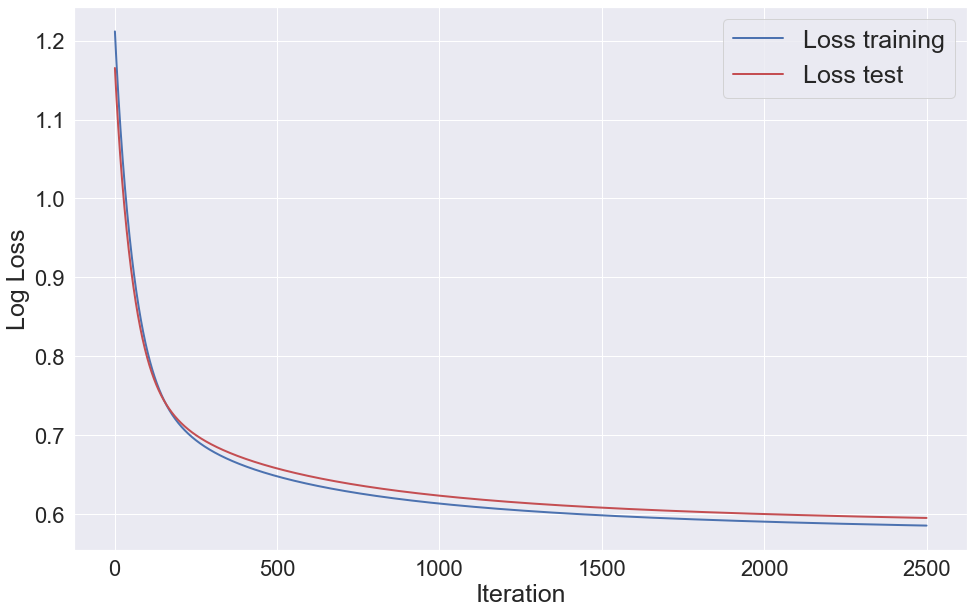

In [37]:
sns.set(font_scale=2)
plt.figure(figsize=([16,10]))
plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
plt.legend(fontsize=25)
plt.ylabel('Log Loss',fontsize=25)
plt.xlabel('Iteration',fontsize=25)
plt.show()

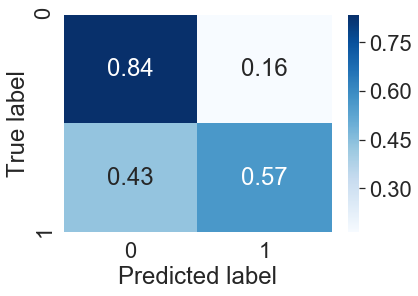

In [38]:
sns.set(font_scale=2)
fig=sns.heatmap(norm, annot=True, cmap=plt.cm.Blues,yticklabels=['0','1'], xticklabels=['0','1'])
fig.set_yticks([0, 2]) 
fig.set_xticks([0.5, 1.5])
fig.set(xlabel='Predicted label', ylabel='True label')
plt.show()      


# Accuracy. 
Både egen kode og tester med scikit. 

In [39]:
print(accuracy_train, '% Training accuracy')
print(accuracy_test, '% Test accuracy')
print(f1_train, '% Training f1 score')
print(f1_test, '% Test f1 score')

70.33040763427591 % Training accuracy
70.10968802992731 % Test accuracy
0.6576801766657719 % Training f1 score
0.6548184493023257 % Test f1 score


# Egen logistisk regresjon med stokastisk gradient descent

In [41]:
eta = 0.1 # learning rate
Niter=2500
k=5
y_folds, x_folds = lrf.k_fold_reshaper(k,y_new,x_new,shuffle=True)
classified = dict()
norm = np.zeros([2,2])
accuracy_train = float()
accuracy_test = float()
f1_train = float()
f1_test = float()

for i in range(k):
    xtrain = x_folds[np.arange(len(x_folds))!=i]      # Featch all but the i-th element
    xtrain = np.concatenate(xtrain,axis=0)
    ytrain = y_folds[np.arange(len(y_folds))!=i]
    ytrain = np.concatenate(ytrain,axis=0)
    xtest  = x_folds[i]
    ytest  = y_folds[i]
    
    logreg = lr.LOGREG(eta=0.1, doplot = False, doprint=False)
    cost_test, cost_train, axis = logreg.fit(xtrain, ytrain, xtest, ytest, Niter, batch_size=int(len(y_new)/20), solver='sgd')
    
    classified=logreg.predict(xtest)
    accuracy_test += 100*np.sum(classified==ytest)/len(classified)
    f1_test += f1_score(ytest, classified)
    norm += fx.norm_confusion_matrix(ytest, classified, normalize=True)
    
    classified=logreg.predict(xtrain)   
    accuracy_train += 100*np.sum(classified==ytrain)/len(classified)
    f1_train += f1_score(ytrain, classified)
    
norm = norm/k
accuracy_train = accuracy_train/k
accuracy_test = accuracy_test/k
f1_train = f1_train/k
f1_test = f1_test/k


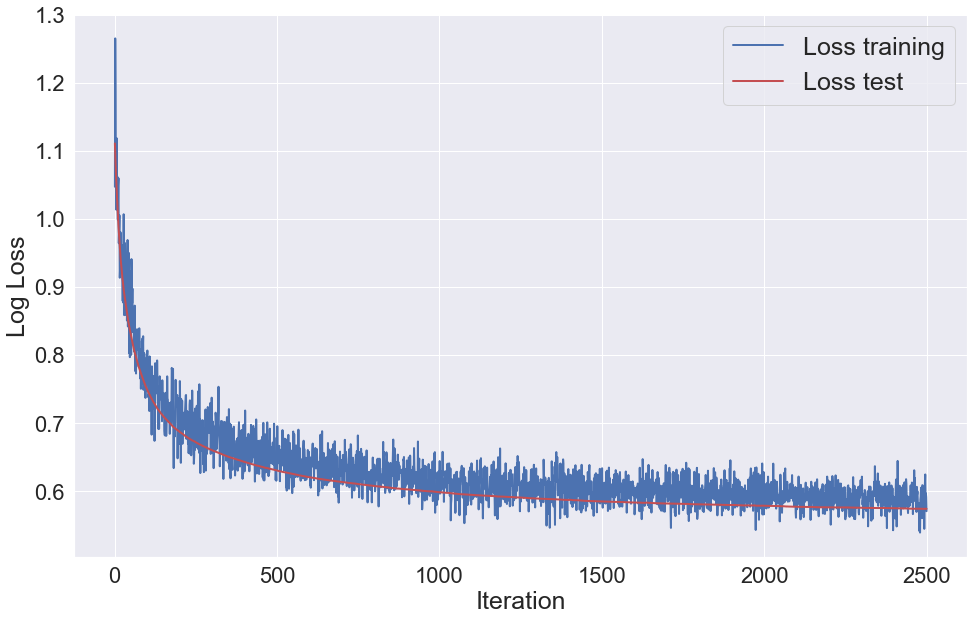

In [42]:
plt.figure(figsize=([16,10]))
plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
plt.legend(fontsize=25)
plt.ylabel('Log Loss',fontsize=25)
plt.xlabel('Iteration',fontsize=25)
plt.show()

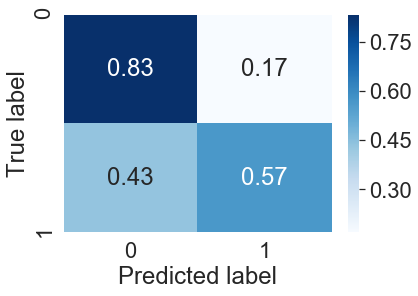

In [43]:
sns.set(font_scale=2)
fig=sns.heatmap(norm, annot=True, cmap=plt.cm.Blues,yticklabels=['0','1'], xticklabels=['0','1'])
fig.set_yticks([0, 2]) 
fig.set_xticks([0.5, 1.5])
fig.set(xlabel='Predicted label', ylabel='True label')
plt.show() 

In [44]:
print(accuracy_train, '% Training accuracy')
print(accuracy_test, '% Test accuracy')
print(f1_train, '% Training f1 score')
print(f1_test, '% Test f1 score')

70.18915298936946 % Training accuracy
69.87659244488756 % Test accuracy
0.6566694185789299 % Training f1 score
0.6526284914969259 % Test f1 score


In [13]:
model = LogisticRegression()
model.fit(xtrain, ytrain)
predicted_classes = model.predict(xtrain)
accuracy = accuracy_score(ytrain.flatten(),predicted_classes)
accuracy = accuracy * 100
parameters = model.coef_

print(accuracy, '% Training Accuracy')


predicted_classes = model.predict(xtest)
accuracy = accuracy_score(ytest.flatten(),predicted_classes)
accuracy = accuracy * 100
parameters = model.coef_

print(accuracy, '% Test Accuracy')

C:\Users\vemundst\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vemundst\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


70.64030131826742 % Training Accuracy
70.51282051282051 % Test Accuracy


# C) 
Neural Network. 

In [14]:
epochs=1000
batch_size=int(len(ytrain)/20)
n_features=x.shape[1]
etavec = np.logspace(-6, -1, 6)
lmbvec = np.logspace(-6, -1, 6)
lmbvec[0]=0

activation = [lrf.relu, lrf.sigmoid, lrf.sigmoid]
derivative = [lrf.relu_deriv, lrf.sigmoid_deriv, lrf.sigmoid_deriv]

train_accuracy = np.zeros((len(etavec), len(lmbvec)))
y_folds, x_folds = lrf.k_fold_reshaper(k,y_new,x_new,shuffle=True)
norm = np.zeros([2,2])
accuracy_train = np.zeros((len(etavec), len(lmbvec)))
accuracy_test = np.zeros((len(etavec), len(lmbvec)))
f1_train = np.zeros((len(etavec), len(lmbvec)))
f1_test = np.zeros((len(etavec), len(lmbvec)))
test_loss = np.zeros((len(etavec), len(lmbvec)))
test_f1 = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 10e-04,\
                                early_stop_nochange=200, mode = 'classification', regularization = 'l1')            
            neural_net.add_layers(n_features=[91,50,20], n_neurons = [50,20,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=False)

            pred = neural_net.feed_out(xtest, activation)
            test_loss[i,j] +=  lrf.cost_log_ols(pred.ravel(),ytest.T)
            test_f1[i,j] +=  f1_score(ytest, np.round(pred))           
            
            classified=np.round(pred)
            
            accuracy_test[i,j] += 100*np.sum(classified==ytest)/len(classified)
            f1_test[i,j] += f1_score(ytest, classified)
            norm += fx.norm_confusion_matrix(ytest, classified, normalize=True)
            
            classified=np.round(neural_net.feed_out(xtrain, activation))   
            accuracy_train[i,j] += 100*np.sum(classified==ytrain)/len(classified)
            f1_train[i,j] += f1_score(ytrain, classified)
        print('test loss for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', test_loss [i,j]/k)

norm = norm/k
accuracy_train = accuracy_train/k
accuracy_test = accuracy_test/k
f1_train = f1_train/k
f1_test = f1_test/k
test_loss = test_loss/k



test loss for η = 1e-06 & λ = 0.0 = 0.7490428721949928
test loss for η = 1e-06 & λ = 1e-05 = 0.7490428716424697
test loss for η = 1e-06 & λ = 0.0001 = 0.7490428666697632
test loss for η = 1e-06 & λ = 0.001 = 0.7490428169426366
test loss for η = 1e-06 & λ = 0.01 = 0.7490423196652729
test loss for η = 1e-06 & λ = 0.1 = 0.749037346282093
test loss for η = 1e-05 & λ = 0.0 = 0.7489689378286083
test loss for η = 1e-05 & λ = 1e-05 = 0.7489689323442887
test loss for η = 1e-05 & λ = 0.0001 = 0.7489688829853492
test loss for η = 1e-05 & λ = 0.001 = 0.7489683893899517
test loss for η = 1e-05 & λ = 0.01 = 0.7489634528359626
test loss for η = 1e-05 & λ = 0.1 = 0.7489140274913543
test loss for η = 0.0001 & λ = 0.0 = 0.748239690792918
test loss for η = 0.0001 & λ = 1e-05 = 0.7482396400202551
test loss for η = 0.0001 & λ = 0.0001 = 0.7482391830611169
test loss for η = 0.0001 & λ = 0.001 = 0.7482346129576793
test loss for η = 0.0001 & λ = 0.01 = 0.7481888607684087
test loss for η = 0.0001 & λ = 0.1 = 0

C:\Users\vemundst\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


test loss for η = 0.01 & λ = 0.1 = 0.7243576526939334
test loss for η = 0.1 & λ = 0.0 = 0.6801783565272608
test loss for η = 0.1 & λ = 1e-05 = 0.6801992017552045
test loss for η = 0.1 & λ = 0.0001 = 0.6804162207526244
test loss for η = 0.1 & λ = 0.001 = 0.6808398611258198
test loss for η = 0.1 & λ = 0.01 = 0.7222664757939368
test loss for η = 0.1 & λ = 0.1 = 0.7241364800437353


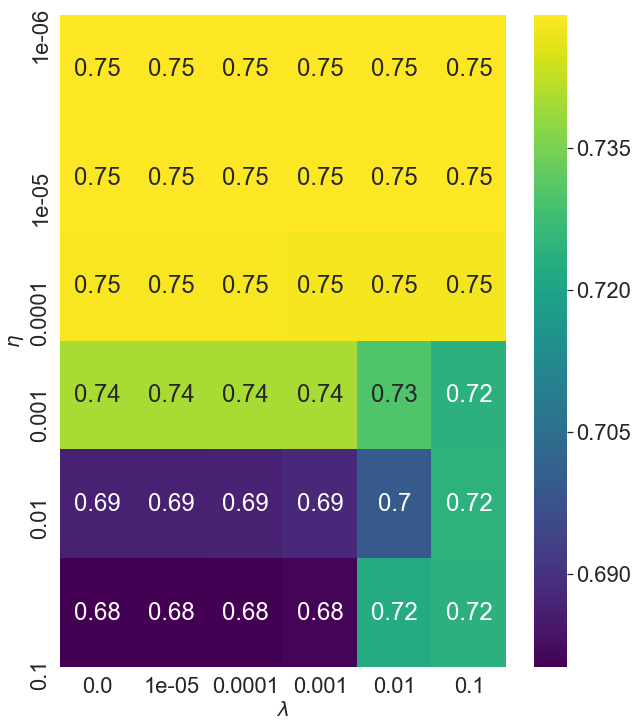

In [15]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_loss, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

In [16]:
best_eta_index, best_lmb_index = np.where(test_loss == np.min(test_loss))
best_eta,best_lmb = etavec[best_eta_index], lmbvec[best_lmb_index] 
print('eta=',best_eta)
print('lmb=',best_lmb)

eta= [0.1]
lmb= [0.]


In [28]:
epochs=1000

norm = np.zeros([2,2])
accuracy_test = 0
f1_test = 0 
accuracy_train = 0
f1_train = 0 
for kf in range(k):
    xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
    xtrain = np.concatenate(xtrain,axis=0)
    ytrain = y_folds[np.arange(len(y_folds))!=kf]
    ytrain = np.concatenate(ytrain,axis=0)
    xtest  = x_folds[kf]
    ytest  = y_folds[kf]
            
    np.random.seed(2019)
    neural_net = nn.ANN(lmb=best_lmb, bias=0, eta=best_eta,early_stop_tol = 0,\
                                early_stop_nochange=200, mode = 'classification', regularization = 'l1')            
    neural_net.add_layers(n_features=[91,50,20], n_neurons = [50,20,1] , n_layers=3)

    neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=True)

    pred = neural_net.feed_out(xtest, activation)
    test_loss[i,j] +=  lrf.cost_log_ols(pred.ravel(),ytest.T)
    test_f1[i,j] +=  f1_score(ytest, np.round(pred))           
            
    classified=np.round(pred)
            
    accuracy_test += 100*np.sum(classified==ytest)/len(classified)
    f1_test += f1_score(ytest, classified)
    norm += fx.norm_confusion_matrix(ytest, classified, normalize=True)
            
    classified=np.round(neural_net.feed_out(xtrain, activation))   
    accuracy_train += 100*np.sum(classified==ytrain)/len(classified)
    f1_train += f1_score(ytrain, classified)
    
norm = norm/k
accuracy_train = accuracy_train/k
accuracy_test = accuracy_test/k
f1_train = f1_train/k
f1_test = f1_test/k
test_loss = test_loss/k
cost_test, cost_train = neural_net.costs()

Epoch 1 loss 0.7445314685062282
Epoch 2 loss 0.7416070838497579
Epoch 3 loss 0.7396965174303306
Epoch 4 loss 0.7380614418544266
Epoch 5 loss 0.7357603566461137
Epoch 6 loss 0.7344725533396668
Epoch 7 loss 0.731676116099777
Epoch 8 loss 0.7288151315875016
Epoch 9 loss 0.7254799595958211
Epoch 10 loss 0.7232371306158151
Epoch 11 loss 0.7192592660795517
Epoch 12 loss 0.7156559957058565
Epoch 13 loss 0.7122199044503695
Epoch 14 loss 0.7100790801636244
Epoch 15 loss 0.7074341158966851
Epoch 16 loss 0.7062958118405585
Epoch 17 loss 0.7042830089580454
Epoch 18 loss 0.7023115352212909
Epoch 19 loss 0.700572002820011
Epoch 20 loss 0.6990208228841901
Epoch 21 loss 0.6983764057349297
Epoch 22 loss 0.6978164810058369
Epoch 23 loss 0.6965174777440183
Epoch 24 loss 0.6954057417935604
Epoch 25 loss 0.6949983281463304
Epoch 26 loss 0.6933784518322791
Epoch 27 loss 0.6923126157349212
Epoch 28 loss 0.6921797892765024
Epoch 29 loss 0.6914864422949264
Epoch 30 loss 0.6906980083831746
Epoch 31 loss 0.68990

Epoch 247 loss 0.6740136521303028
Epoch 248 loss 0.6739387165762061
Epoch 249 loss 0.673790834449892
Epoch 250 loss 0.6733565183991892
Epoch 251 loss 0.673158201041731
Epoch 252 loss 0.673809387793018
Epoch 253 loss 0.6735144452662069
Epoch 254 loss 0.6733233427094755
Epoch 255 loss 0.672761778763686
Epoch 256 loss 0.6727464515496164
Epoch 257 loss 0.6739259863395509
Epoch 258 loss 0.673301455028822
Epoch 259 loss 0.673351982769047
Epoch 260 loss 0.673623067515324
Epoch 261 loss 0.6735314545721105
Epoch 262 loss 0.6732645353321545
Epoch 263 loss 0.6732443833171373
Epoch 264 loss 0.6732945990663127
Epoch 265 loss 0.6735946791792428
Epoch 266 loss 0.6729150891838936
Epoch 267 loss 0.6732269660610039
Epoch 268 loss 0.6733896903813531
Epoch 269 loss 0.673383637163055
Epoch 270 loss 0.6739907389196051
Epoch 271 loss 0.6738589797102253
Epoch 272 loss 0.6728141577158481
Epoch 273 loss 0.6729023605947781
Epoch 274 loss 0.6735395732224155
Epoch 275 loss 0.673968314739465
Epoch 276 loss 0.672818

Epoch 489 loss 0.6718397139801399
Epoch 490 loss 0.6717100310920638
Epoch 491 loss 0.671861820655566
Epoch 492 loss 0.6717372326639728
Epoch 493 loss 0.6716970455407618
Epoch 494 loss 0.6713733667214136
Epoch 495 loss 0.6717009778247366
Epoch 496 loss 0.6717724331489814
Epoch 497 loss 0.6718240567294687
Epoch 498 loss 0.6713111421536796
Epoch 499 loss 0.6717507186973816
Epoch 500 loss 0.6715656315913777
Epoch 501 loss 0.671711728809671
Epoch 502 loss 0.6713301794900719
Epoch 503 loss 0.6721508755523125
Epoch 504 loss 0.6720820238992051
Epoch 505 loss 0.6712525014052061
Epoch 506 loss 0.6719336948231538
Epoch 507 loss 0.6718619867480998
Epoch 508 loss 0.6714129147032918
Epoch 509 loss 0.6710375441942862
Epoch 510 loss 0.6719611755281668
Epoch 511 loss 0.6726048201656359
Epoch 512 loss 0.6719285129810143
Epoch 513 loss 0.6718983327738179
Epoch 514 loss 0.6719907993260582
Epoch 515 loss 0.6720241299955362
Epoch 516 loss 0.6719481859895864
Epoch 517 loss 0.6720232485484431
Epoch 518 loss 0

Epoch 195 loss 0.6817575111729207
Epoch 196 loss 0.6810895769764
Epoch 197 loss 0.6815230365034958
Epoch 198 loss 0.6817721021959668
Epoch 199 loss 0.6821434327970287
Epoch 200 loss 0.6822378311303393
Epoch 201 loss 0.6814282571049994
Epoch 202 loss 0.6821949378684357
Epoch 203 loss 0.6814807470935392
Epoch 204 loss 0.6812056314351953
Epoch 205 loss 0.6818266121761183
Epoch 206 loss 0.6817014359672252
Epoch 207 loss 0.6818247595172843
Epoch 208 loss 0.6817845818153022
Epoch 209 loss 0.6817114297738127
Epoch 210 loss 0.681873555133765
Epoch 211 loss 0.6814770151842541
Epoch 212 loss 0.6808044274356778
Epoch 213 loss 0.6818524989195832
Epoch 214 loss 0.6814456140058074
Epoch 215 loss 0.6799758528765606
Epoch 216 loss 0.680892107645444
Epoch 217 loss 0.6820292543867222
Epoch 218 loss 0.6822274464131267
Epoch 219 loss 0.6814335453417624
Epoch 220 loss 0.6809625712381515
Epoch 221 loss 0.6815344406122686
Epoch 222 loss 0.6817199849953465
Epoch 223 loss 0.6817381787492229
Epoch 224 loss 0.68

Epoch 437 loss 0.6791082595152964
Epoch 438 loss 0.6796556357053738
Epoch 439 loss 0.679192521265215
Epoch 440 loss 0.6789982472295933
Epoch 441 loss 0.6788567512122186
Epoch 442 loss 0.6792022650967011
Epoch 443 loss 0.6790560384982712
Epoch 444 loss 0.6781761627505929
Epoch 445 loss 0.6786946515976408
Epoch 446 loss 0.6781416362205543
Epoch 447 loss 0.6783347637714031
Epoch 448 loss 0.6787291508623751
Epoch 449 loss 0.6791119407666616
Epoch 450 loss 0.6783409719831696
Epoch 451 loss 0.678587506141909
Epoch 452 loss 0.6799306499871006
Epoch 453 loss 0.6806222518668532
Epoch 454 loss 0.6797660820292293
Epoch 455 loss 0.680446002446536
Epoch 456 loss 0.6800313507521608
Epoch 1 loss 0.7393831841730022
Epoch 2 loss 0.7374627229903985
Epoch 3 loss 0.7368323926841399
Epoch 4 loss 0.7354513133848624
Epoch 5 loss 0.7329488082066835
Epoch 6 loss 0.7314189724869223
Epoch 7 loss 0.7286579808859838
Epoch 8 loss 0.7257227298842157
Epoch 9 loss 0.722840666638819
Epoch 10 loss 0.7194672105880945
Epo

Epoch 227 loss 0.6732104341182759
Epoch 228 loss 0.6732135023126277
Epoch 229 loss 0.6738354556717412
Epoch 230 loss 0.6736871038617506
Epoch 231 loss 0.6737663265806462
Epoch 232 loss 0.6729247162539939
Epoch 233 loss 0.6725950847986256
Epoch 234 loss 0.6735569090365188
Epoch 235 loss 0.673851309960126
Epoch 236 loss 0.6741512953228035
Epoch 237 loss 0.6737217250820696
Epoch 238 loss 0.6734380228240617
Epoch 239 loss 0.6728354289205098
Epoch 240 loss 0.6725308537093305
Epoch 241 loss 0.6725795923267106
Epoch 242 loss 0.6729809600558176
Epoch 243 loss 0.6733482297420968
Epoch 244 loss 0.6735056584677269
Epoch 245 loss 0.6730821642385382
Epoch 246 loss 0.6729091068071158
Epoch 247 loss 0.6730203721526745
Epoch 248 loss 0.6731150158318859
Epoch 249 loss 0.6730439719187178
Epoch 250 loss 0.6729880735237244
Epoch 251 loss 0.6719563557795298
Epoch 252 loss 0.6729311896201119
Epoch 253 loss 0.6730105943584629
Epoch 254 loss 0.6729719138573406
Epoch 255 loss 0.6724157979841904
Epoch 256 loss 

Epoch 66 loss 0.6982526821853084
Epoch 67 loss 0.6983180261897597
Epoch 68 loss 0.69782814536095
Epoch 69 loss 0.6995785624528849
Epoch 70 loss 0.6995960926282635
Epoch 71 loss 0.6974637490230117
Epoch 72 loss 0.6972611012872112
Epoch 73 loss 0.6965527086944379
Epoch 74 loss 0.6975390483706411
Epoch 75 loss 0.6976648715135071
Epoch 76 loss 0.6967039412032091
Epoch 77 loss 0.6973400798553896
Epoch 78 loss 0.6962638217692647
Epoch 79 loss 0.6960244946439952
Epoch 80 loss 0.6968368141347856
Epoch 81 loss 0.6966106496522372
Epoch 82 loss 0.6976697799137072
Epoch 83 loss 0.6972681885155659
Epoch 84 loss 0.6962651232041535
Epoch 85 loss 0.6962465270057313
Epoch 86 loss 0.6966687174120796
Epoch 87 loss 0.6962824330934614
Epoch 88 loss 0.6970938564810332
Epoch 89 loss 0.6957737874838414
Epoch 90 loss 0.6962814289766536
Epoch 91 loss 0.6958352068918165
Epoch 92 loss 0.6961945437655674
Epoch 93 loss 0.6963642507011039
Epoch 94 loss 0.6964996066401326
Epoch 95 loss 0.6954609950994571
Epoch 96 los

Epoch 309 loss 0.6903114211312452
Epoch 310 loss 0.6899249099264142
Epoch 311 loss 0.6902959939204505
Epoch 312 loss 0.6901118623355861
Epoch 313 loss 0.6910172182245966
Epoch 314 loss 0.6911671077325569
Epoch 315 loss 0.6906050347846684
Epoch 316 loss 0.6898545362813366
Epoch 317 loss 0.6900633150132427
Epoch 318 loss 0.6902339039258242
Epoch 319 loss 0.6905325610769409
Epoch 320 loss 0.690764110884494
Epoch 321 loss 0.6908657160327666
Epoch 322 loss 0.6898632657282281
Epoch 323 loss 0.6908232420710743
Epoch 324 loss 0.6908551935448357
Epoch 325 loss 0.6907834539354921
Epoch 326 loss 0.6906263479960635
Epoch 327 loss 0.6902319721621271
Epoch 328 loss 0.6916281559209274
Epoch 329 loss 0.6912970930524371
Epoch 330 loss 0.690775831657289
Epoch 331 loss 0.6906236216222054
Epoch 332 loss 0.6909870091416113
Epoch 333 loss 0.6900454200533906
Epoch 334 loss 0.690582224553092
Epoch 335 loss 0.6910112721591181
Epoch 336 loss 0.691456383677451
Epoch 337 loss 0.6908793118896394
Epoch 338 loss 0.6

Epoch 100 loss 0.6872386130840447
Epoch 101 loss 0.6875143847332502
Epoch 102 loss 0.6870743237155758
Epoch 103 loss 0.6871919567217423
Epoch 104 loss 0.6876159170584197
Epoch 105 loss 0.6881738336368133
Epoch 106 loss 0.688554013706841
Epoch 107 loss 0.6880619157724317
Epoch 108 loss 0.6872827551638633
Epoch 109 loss 0.6873521688549629
Epoch 110 loss 0.6874363531827656
Epoch 111 loss 0.6875124752895667
Epoch 112 loss 0.6877812688596306
Epoch 113 loss 0.6870969895820853
Epoch 114 loss 0.6882463986124707
Epoch 115 loss 0.6866832724853779
Epoch 116 loss 0.686964611386877
Epoch 117 loss 0.6880589750415385
Epoch 118 loss 0.6876124619608872
Epoch 119 loss 0.686944508696036
Epoch 120 loss 0.6868442569699522
Epoch 121 loss 0.687514875042564
Epoch 122 loss 0.6871205117426469
Epoch 123 loss 0.6869070573447532
Epoch 124 loss 0.6870827720107179
Epoch 125 loss 0.6875112287253039
Epoch 126 loss 0.6868361651923053
Epoch 127 loss 0.6876629249735096
Epoch 128 loss 0.6866976283042753
Epoch 129 loss 0.6

Epoch 342 loss 0.6842994658699881
Epoch 343 loss 0.6843658212629846
Epoch 344 loss 0.6827349744364821
Epoch 345 loss 0.6842657542990025
Epoch 346 loss 0.6842104636839269
Epoch 347 loss 0.6833886775371643
Epoch 348 loss 0.6839407031254544
Epoch 349 loss 0.6832657324851387
Epoch 350 loss 0.6834027337937381
Epoch 351 loss 0.6832680965160112
Epoch 352 loss 0.6830811095244747
Epoch 353 loss 0.6836936098666558
Epoch 354 loss 0.6832432924300033
Epoch 355 loss 0.6832962730623245
Epoch 356 loss 0.6834132911258254
Epoch 357 loss 0.6839756565942642
Epoch 358 loss 0.6837253955763852
Epoch 359 loss 0.6840553814092377
Epoch 360 loss 0.6827821868884796
Epoch 361 loss 0.6844409581837462
Epoch 362 loss 0.6840522458087054
Epoch 363 loss 0.684072423283498
Epoch 364 loss 0.6842405109152166
Epoch 365 loss 0.6831943840806791
Epoch 366 loss 0.6841499969069312
Epoch 367 loss 0.6836214605724839
Epoch 368 loss 0.6840491468637354
Epoch 369 loss 0.6840488917517185
Epoch 370 loss 0.6835560318753301
Epoch 371 loss 

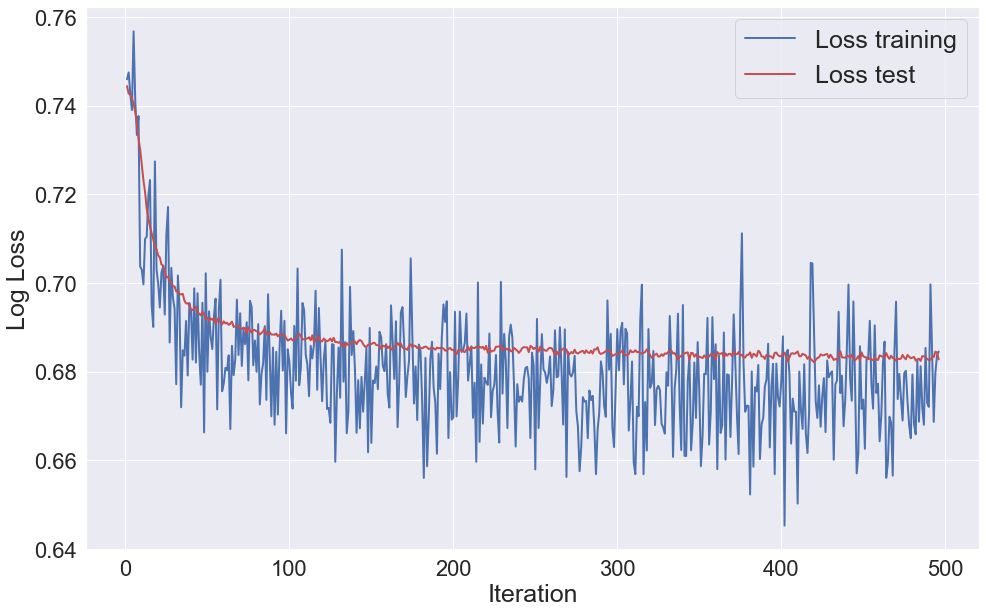

In [29]:
plt.figure(figsize=([16,10]))
axis = np.arange(len(cost_train))+1
plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
plt.legend(fontsize=25)
plt.ylabel('Log Loss',fontsize=25)
plt.xlabel('Iteration',fontsize=25)
plt.show()

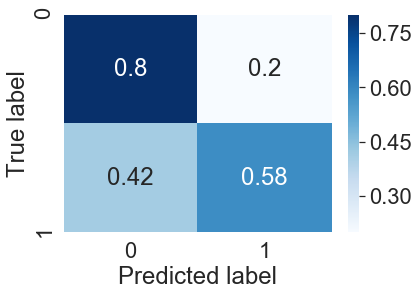

In [30]:
fig=sns.heatmap(norm, annot=True, cmap=plt.cm.Blues,yticklabels=['0','1'], xticklabels=['0','1'])
fig.set_yticks([0, 2]) 
fig.set_xticks([0.5, 1.5])
fig.set(xlabel='Predicted label', ylabel='True label')
plt.show() 


In [31]:
print(accuracy_train, '% Training accuracy')
print(accuracy_test, '% Test accuracy')
print(f1_train, '% Training f1 score')
print(f1_test, '% Test f1 score')

70.2135919953555 % Training accuracy
69.23589914018628 % Test accuracy
0.6662639110474164 % Training f1 score
0.6550781067939491 % Test f1 score


In [22]:
from sklearn.neural_network import MLPClassifier
# by default MLPClassifier employes l2 regularization


#print("Test set score: %f" % mlp.score(xtest, ytest))
epochs=1000
batch_size=500
n_features=x.shape[1]
etavec = np.logspace(-4, -1, 4)
lmbvec = np.logspace(-7, -3, 5)
lmbvec[0]=0


train_accuracy = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        mlp = MLPClassifier(hidden_layer_sizes=(50,20,), max_iter=2000, alpha=lmb,
                    solver='sgd', verbose=0, tol=1e-4,batch_size=500, random_state=1,
                    learning_rate_init=etas)

        mlp.fit(xtrain, ytrain.ravel())
        print("Training set score: %f" % mlp.score(xval, yval))
        pred = mlp.predict(xval)
        train_accuracy[i,j] =  lrf.cost_log_ols(pred.ravel(),yval.T)
        print('Validation f1_score for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', train_accuracy [i,j])



Training set score: 0.706325
Validation f1_score for η = 0.0001 & λ = 0.0 = 0.637097362413115
Training set score: 0.706325
Validation f1_score for η = 0.0001 & λ = 1e-06 = 0.637097362413115
Training set score: 0.706325
Validation f1_score for η = 0.0001 & λ = 1e-05 = 0.637097362413115
Training set score: 0.706325
Validation f1_score for η = 0.0001 & λ = 0.0001 = 0.637097362413115
Training set score: 0.706325
Validation f1_score for η = 0.0001 & λ = 0.001 = 0.637097362413115
Training set score: 0.718373
Validation f1_score for η = 0.001 & λ = 0.0 = 0.6274553591914801
Training set score: 0.718373
Validation f1_score for η = 0.001 & λ = 1e-06 = 0.6274553591914801
Training set score: 0.718373
Validation f1_score for η = 0.001 & λ = 1e-05 = 0.6274553591914801
Training set score: 0.718373
Validation f1_score for η = 0.001 & λ = 0.0001 = 0.6274553591914801
Training set score: 0.718373
Validation f1_score for η = 0.001 & λ = 0.001 = 0.6274553591914801
Training set score: 0.673946
Validation f1

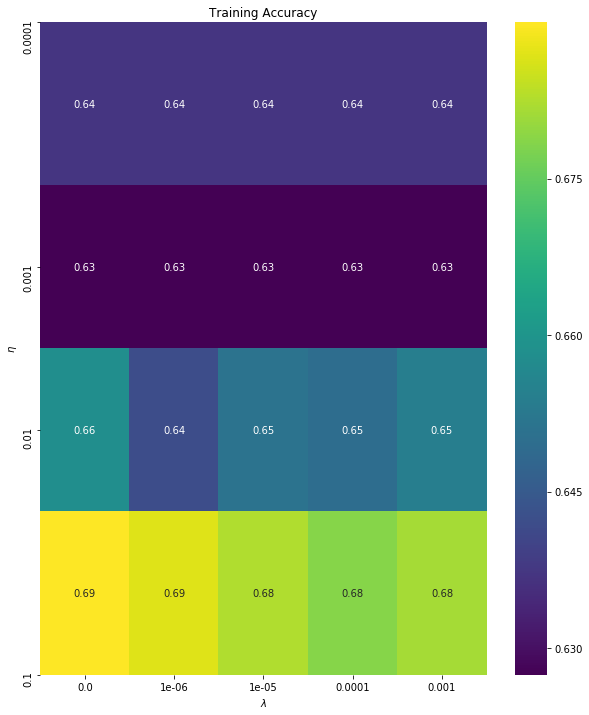

In [23]:
import seaborn as sns
train_accuracy[np.isnan(train_accuracy)]=2

yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

In [24]:
pred = mlp.predict(xtest)
accuracy = accuracy_score(ytest.flatten(),pred)
accuracy = accuracy * 100
print(accuracy)
print(f1_score(ytest, pred)) 

cm = confusion_matrix(ytest , pred)
print(cm)

66.17702448210923
0.6801994301994302
[[802 573]
 [325 955]]


In [25]:
pred = mlp.predict(xtrain)
accuracy = accuracy_score(ytrain.flatten(),pred)
accuracy = accuracy * 100
print(accuracy)

cm = confusion_matrix(ytrain , pred)
print(cm)

75.83162880826785
[[3137 1473]
 [ 772 3907]]


# Cancer data

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler

xtrain,ytrain = load_breast_cancer(return_X_y=True)
scaler = MinMaxScaler()
indx = np.arange(xtrain.shape[1])
scaler.fit(xtrain[:,indx])
xtrain = scaler.transform(xtrain[:,indx])
ytrain=ytrain.reshape([len(ytrain),1])